## Introduction
In this notebook, different approaches to drawing a network that has already been layed out, are experimented with.

Input networks used in this notebook are generated by passing randomly generated nodes and connections through the layout algorithm. implemented in [idlmav_layout.py](../idlmav_layout.py). This algorithm was experimented with in [01_explore_layout.ipynb](./01_explore_layout.ipynb), implemented in [idlmav_layout.py](../idlmav_layout.py) and verified in [test_layout.py](./test_layout.ipynb).



## Imports

In [1]:
import sys
import os
workspace_path = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
sys.path.append(workspace_path)

In [2]:
from idlmav_types import MavNode, MavGraph, MavConnection
from idlmav_layout import create_random_sample_graph, layout_graph_nodes
from idlmav_static_viewers import ArcViewer, PlotlyViewer
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, HTML

In [3]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"  # Avoids copying the 4 MB plotly contents to the notebook DOM

## Graph layouts

In [4]:
np.random.seed(2)
nodes, connections = create_random_sample_graph([1,2,3,4,3,2,1], 20, 0.1, 0.1)
g_xsmall = MavGraph(nodes, connections)
layout_graph_nodes(g_xsmall)

np.random.seed(2)
nodes, connections = create_random_sample_graph([1,2,3,4,3,2,1,2,3,3,2,1], 40, 0.1, 0.1)
g_small = MavGraph(nodes, connections)
layout_graph_nodes(g_small)

np.random.seed(2)
nodes, connections = create_random_sample_graph([1,2,3,2,1,2,3,4,3,2,3,2,2,1,3,2,1], 60, 0.1, 0.1)
g_medium = MavGraph(nodes, connections)
layout_graph_nodes(g_medium)

## Static matplotlib graph
* No interactions (e.g. pan, zoom, click/hover for detail)
* Used as baseline to verify other view options

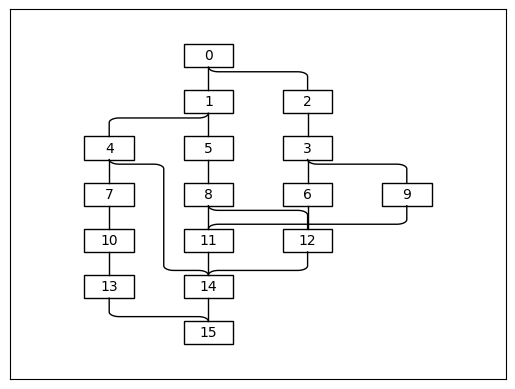

In [5]:
ArcViewer(g_xsmall).draw()

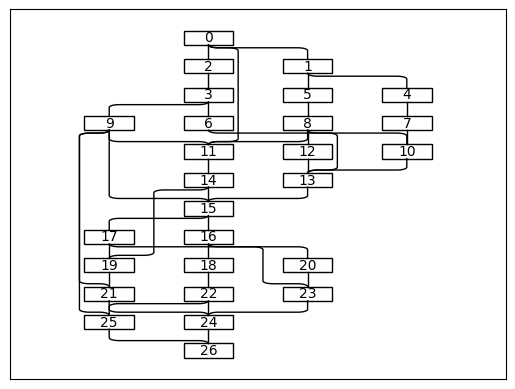

In [6]:
ArcViewer(g_small).draw()

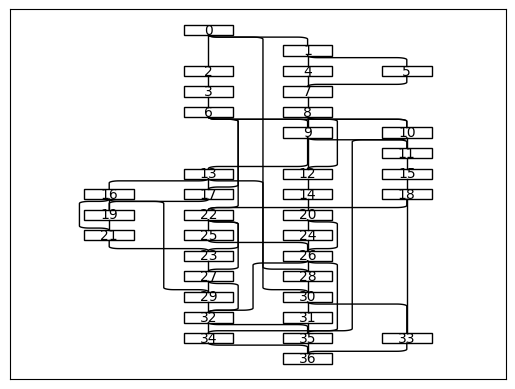

In [7]:
ArcViewer(g_medium).draw()

## Standalone plotly graph
* Hover interactions only
* No zoom & scroll interactions, except those provided by plotly

In [8]:
PlotlyViewer(g_medium).draw()

## Matplotlib graph inside ipywidgets scroll box

In [9]:
fig = ArcViewer(g_medium).draw()
buf = BytesIO()
fig.savefig(buf, format='png')
buf.seek(0)
image_widget = widgets.Image(value=buf.read(), format='png')
inner_box = widgets.Box([image_widget], layout=widgets.Layout(height="1000px"))
scrollable2 = widgets.Box([inner_box], layout=widgets.Layout(height="500px", object_fit="none", overflow="hidden scroll"))
display(scrollable2)

Box(children=(Box(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\…

## Plotly graph inside ipywidgets scroll box

In [10]:
fig = PlotlyViewer(g_medium).draw()
fig_widget = go.FigureWidget(fig)
fig_widget.update_layout(height=1000)  # Make it tall
inner_box = widgets.Box([fig_widget], layout=widgets.Layout(height="1000px"))
scrollable2 = widgets.Box([inner_box], layout=widgets.Layout(height="500px", object_fit="none", overflow="hidden scroll"))
display(scrollable2)

Box(children=(Box(children=(FigureWidget({
    'data': [{'customdata': [['0', [80, 500, 830], 9970, 3070], ['1…

## Plotly graph with ipywidgets slider as scrollbar
This viewer uses plotly to draw the network. The network is scaled to fit the width of the axes and vertical panning is performed using a single ipywidgets control

### Exploratory example: scatter plot
* This just draws a scatter plot with x and y ranges configurable using sliders from `ipywidgets`
* This was done for a generic graph first, because the concept seems very reusable

In [11]:
initial_x_range = [0,40]
initial_y_range = [0,40]

# Generate some scatter plot data: 500 items having 6 fields each
# * 1st field: x-coordinate 
# * 2nd field: y-coordinate
# * 3rd field: dot size
# * 4th field: dot color
# * All fields: hover info
np.random.seed(42)
data = np.random.uniform(0, 100, (500, 6))
x = np.random.uniform(0, 100, 500)
y = np.random.uniform(0, 100, 500)

# Define pairs of indices to connect with lines (example pairs)
pairs = [(0, 1), (50, 100), (200, 250), (300, 400)]

# Create initial figure with zoomed-in axes (0 to 10)
fig = go.FigureWidget(
    data=go.Scatter(
        x=data[:,0], 
        y=data[:,1], 
        mode='markers', 
        marker=dict(
            size=data[:, 2] / 10,
            color=data[:, 3],
            colorscale='Viridis',
            colorbar=dict(title='Color')
        ),
        hovertemplate=(
            'Field 1 (X): %{x}<br>' +
            'Field 2 (Y): %{y}<br>' +
            'Field 3 (Size): %{marker.size}<br>' +
            'Field 4 (Color): %{marker.color}<br>' +
            'Field 5: %{customdata[0]}<br>' +
            'Field 6: %{customdata[1]}'
        ),
        customdata=data[:, 4:6]  # Fields 5 and 6 for custom hover data
    ),
    layout=go.Layout(
        xaxis=dict(range=initial_x_range, title='Field 1 (X)'),
        yaxis=dict(range=initial_y_range, title='Field 2 (Y)', autorange='reversed'),
        title="Zoomed Scatter Plot with Panning Sliders",
        width=500,
        height=500
    )
)

# Add line segments to connect each pair
for i, j in pairs:
    fig.add_trace(
        go.Scatter(
            x=[data[i, 0], data[j, 0]],  # X coordinates of the two points in the pair
            y=[data[i, 1], data[j, 1]],  # Y coordinates of the two points in the pair
            mode="lines",
            line=dict(color="gray", width=1),
            showlegend=False
        )
    )

# Create sliders for panning the view
x_slider = widgets.FloatRangeSlider(
    value=initial_x_range, min=0, max=100, step=1,
    description='X Range:', continuous_update=False,
    layout=widgets.Layout(width='400px')
)

y_slider = widgets.FloatRangeSlider(
    value=initial_y_range, min=0, max=100, step=1,
    description='Y Range:', orientation='vertical', continuous_update=False,
    layout=widgets.Layout(height='400px')
)

# Put the sliders in boxes to control alignment
x_slider_box = widgets.VBox([x_slider], layout=widgets.Layout(align_items='center', justify_content='center', width="500px"))
y_slider_box = widgets.HBox([y_slider], layout=widgets.Layout(align_items='center', justify_content='center', height="500px"))
fig_box      = widgets.VBox([fig], layout=widgets.Layout(align_items='center', justify_content='center', width="500px", height="500px"))

# Define a function to update the axis range based on slider values
def update_plot(change):
    fig.update_layout(
        xaxis=dict(range=x_slider.value),
        yaxis=dict(range=y_slider.value)
    )

# Link the sliders to the update function
x_slider.observe(update_plot, names="value")
y_slider.observe(update_plot, names="value")

# Display the plot and sliders in a 2x2 grid
grid = widgets.GridspecLayout(2, 2, height="600px", width="600px")
grid[1, 1] = x_slider_box
grid[0, 0] = y_slider_box
grid[0, 1] = fig_box
display(grid)

GridspecLayout(children=(VBox(children=(FloatRangeSlider(value=(0.0, 40.0), continuous_update=False, descripti…

### Visualizing the network

In [12]:
g = g_medium
in_level = g.in_nodes[0].y
out_level = g.out_nodes[0].y
num_levels = out_level - in_level + 1
disp_levels = min((num_levels,10))

# Draw using plotly
fig = PlotlyViewer(g_medium).draw()
fig_widget = go.FigureWidget(fig)

# Add slider for pan & zoom
# * Specify negative values to the slider, because it wants low values at the bottom
#   and high values on top (inverting it by using max < min raises an exception)
y_slider = widgets.FloatRangeSlider(
    value=[-in_level+0.5-disp_levels,-in_level+0.5], min=-out_level-0.5, max=-in_level+0.5, step=0.01,
    description='', orientation='vertical', continuous_update=False,
    layout=widgets.Layout(height='400px')
)
y_slider.readout = False  # For some reason it does not seem to work if set during construction

# Define a function to update the axis range based on slider values
# * Take the negative of the y_slider values again to undo the reversal (see above)
def update_plot(change):
    fig_widget.update_layout(
        yaxis=dict(range=[-y_slider.value[0], -y_slider.value[1]])
    )

# Apply it the first time
update_plot(None)

# Link the slider to the update function
y_slider.observe(update_plot, names="value")

# Put everything together and display
fig_box = widgets.VBox([fig_widget], layout=widgets.Layout(align_items='center', justify_content='center', width="500px", height="500px"))
y_slider_box = widgets.HBox([y_slider], layout=widgets.Layout(align_items='center', justify_content='center', height="500px"))
display(widgets.HBox([y_slider_box,fig_widget], layout=widgets.Layout(align_items="center", width="600px")))